In [1]:
!pip3 install -q langdetect

# <center><span style="color:#FF0000;">Table of Contents</span>
<a id="toc"></a>
- [1. Introduction](#1)
- [2. Imports](#2)
- [3. EDA](#3)
    - [3.1 Train Data](#3.1)
        - [3.1.1 Train Data Distribution ](#3.1.1)
    - [3.2 Code Cell Analysis](#3.2)
        - [3.2.1 Code Cells Length Distribution ](#3.2.1)
        - [3.2.2 Code Cells WordCloud ](#3.2.2)
    - [3.3 Markdown Cell Analysis](#3.2)
        - [3.3.1 Markdown Cells Length Distribution ](#3.3.1)
        - [3.3.2 Markdown Cells WordCloud ](#3.3.2)
    - [3.4 Notebooks Analysis](#3.4)
        - [3.4.1 Code Cell Count Analysis ](#3.4.1)
        - [3.4.2 Markdown Cell Count Analysis ](#3.4.2)
        - [3.4.3 Minimum Cell Count Analysis ](#3.4.3)

<a id="1"></a>
# **<center><span style="color:#fd7c6e;">Introduction </span></center>**

<b>The goal of this competition is to understand the relationship between code and comments in Python notebooks. You are challenged to reconstruct the order of markdown cells in a given notebook based on the order of the code cells, demonstrating comprehension of which natural language references which code.</b><br>

<b>Predictions are evaluated by the Kendall tau correlation between predicted cell orders and ground truth cell orders accumulated across the entire collection of test set notebooks.</b><br>

<b>Check more about Kendall tau correlation - https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient</b>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
# **<center><span style="color:#fd7c6e;">Imports </span></center>**

In [2]:
import os, re, gc
import nltk, string
import json
import wordcloud
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm, trange
from langdetect import detect_langs
import seaborn as sns

## <span style="color:#e76f51;"> Loading Data : </span>


Pandas Dataframe used is created by [Darien Schettler](https://www.kaggle.com/dschettler8845). Link to dataset - https://www.kaggle.com/datasets/dschettler8845/ai4code-train-dataframe

In [3]:
## train dataframes
df = pd.read_csv("../input/ai4code-train-dataframe/train.csv", index_col= [0,1])
df.dropna(inplace = True)

df_ancestors = pd.read_csv('../input/AI4Code/train_ancestors.csv', index_col='id')
df_orders = pd.read_csv("../input/AI4Code/train_orders.csv",index_col='id',squeeze=True,).str.split()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3"></a>
# **<center><span style="color:#fd7c6e;">EDA</span></center>**

<div  style="font-size:14px; font-family:verdana; line-height: 1.7em; background-color:#FFD580;">
    📌 &nbsp;<b><u>Observations :</u></b><br>

* <i> A total of <b><u>139256</u></b> notebooks are provided <b><u>train</u></b> set.</i><br>
* <i> A total of <b><u>4</u></b> notebooks are provided <b><u>test</u></b> set. This will be replaced with a <b><u> hidden test</u></b> set for scoring</i><br>
* <i> There are total of <b><u>146300</u></b> cells in <b><u>train </u></b>the train dataframe constructed which include two types of cell_type.</i><br>
* <i> Two types of cell_type - <b><u>code</u></b> and <b><u>markdown</u></b>.</i>
* <i> Almost <b><u>2/3rd</u></b> of the training data consist of Code Cells and remaining <b><u>1/3rd</u></b> consist of Markdown Cells.</i>
</div>

In [4]:
print(f"\033[94mNumber of notebooks present in train set  = ",len(os.listdir("../input/AI4Code/train")))
print(f"\033[94mNumber of notebooks present in test set  = ",len(os.listdir("../input/AI4Code/test")))

Number of notebooks present in train set  =  139256
Number of notebooks present in test set  =  4


<a id="3.1"></a>
### <span style="color:#e76f51;"> Quick View of train data  : </span>

<div style="font-size:14px; font-family:verdana; line-height: 1.7em; background-color:#FFD580;">
    📌 &nbsp;<b>`df` is a Multi-level indexing Padnas Dataframe with 2 index - id and cell_id. </b><br>
Learn more about Multi-level indexing Padnas Dataframe - https://pandas.pydata.org/docs/user_guide/advanced.html
</div>

In [5]:
df.head()

cell_type  \
id             cell_id              
8a2564b730a575 8395ab7c      code   
               ebc844d6      code   
               49251f17      code   
               3a6623e3      code   
               24e09d1a      code   

                                                                    source  
id             cell_id                                                      
8a2564b730a575 8395ab7c  import numpy as np\nimport matplotlib.pyplot a...  
               ebc844d6  df_train = pd.read_csv('../input/tensorflow-gr...  
               49251f17  def bbox_inv_iou(boxA, boxB):\n    """Copied f...  
               3a6623e3  test_sequence_id = np.unique(df_train.sequence...  
               24e09d1a  seq_df_with_cots_ids, stats = find_unique_cots...

>**Training data consists out of 139256 JSON files, each containing a notebook where markdown cells have been shuffeled. Additional files regarding correct markdown order, as well as, information of "forked notebook" has also been given. Following table is a combination of all given training files, including the correct order and ancestor_id/parent_id.**

>> * **`id` - Unique identification of notebook.** 
>>* **`cell_id` - Unique identification of cell within notebooks.** 
>>* **`cell_type` - Factor specifying cell type, either being a code cell or markdown cell.** 
>>* **`source` - String with content of cell.**
>>* **`ancestor_id` - Identifies sets of notebooks with common origin.**
>>* **`parent_id` - Some version of the notebook id was forked from some version of the notebook `parent_id`. It may or may not be present (i.e. `parent_id` may be missing due to someone having forked a private notebook).** 

In [6]:
df_ancestors.head(5)

ancestor_id       parent_id
id                                        
00001756c60be8    945aea18             NaN
00015c83e2717b    aa2da37e  317b65d12af9df
0001bdd4021779    a7711fde             NaN
0001daf4c2c76d    090152ca             NaN
0002115f48f982    272b483a             NaN

**`train_ancestors.csv`** 
- On Kaggle, a user may "fork" (that is, copy) the notebook of another user to create their own version. This file contains the forking history of notebooks in the training set. Note: There is no corresponding file for the test set.
- **Columns**
    * **`ancestor_id`**
        * Identifies sets of notebooks that have a common origin or "ancestor". 
        * As no notebook in the test set has an ancestor in the training set, you may find this field to be of use as a grouping factor when constructing validation splits.
    * **`parent_id`**
        * Indicates that some version of the notebook id was forked from some version of the notebook **`parent_id`**. 
        * The notebook **`parent_id`** may or may not be present in the training data. 
            * The parent may be missing because someone had forked a private notebook of their own, for instance.

<a id="3.1.1"></a>
### <span style="color:#e76f51;"> Train data distribution  : </span>

In [7]:
code_df = df[df["cell_type"] == "code"]
mkd_df = df[df["cell_type"] == "markdown"]


print(f'\033[94mNumber of Code Cells: {len(code_df)}')
print(f'\033[94mNumber of Markdown Cells: {len(mkd_df)}')

labels=['Code Cells', 'Markdown Cells']
values= [len(code_df), len(mkd_df)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, 
    pull=[0.1, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

Number of Code Cells: 4204578
Number of Markdown Cells: 2166064


<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3.2"></a>
## <span style="color:#e76f51;"> Code cells analysis  : </span>

<div style="font-size:14px; font-family:verdana; line-height: 1.7em; background-color:#FFD580;">
    📌 &nbsp;<b><u>Observations:</u></b><br>

* <i> Mean Length for Code Cells is <b><u>25 words</u></b></i><br>
* <i> Max words in a Code Cell is <b><u>74589 words</u></b></i><br>
* <i> There are many outliers in Code Cells</i><br>
</div>

### <span style="color:#e76f51;"> Sample Code Cell: </span>

In [8]:
print(f'\033[94m')
print(code_df.iloc[0]["source"])


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import uuid
import os
import scipy
import cv2
from tqdm import tqdm
import math
import ast
sns.set()


<a id="3.2.1"></a>
### <span style="color:#e76f51;"> Code cells Length Distribution  : </span>

In [9]:
code_lengths = np.array([len(code_df["source"][i].split()) for i in range(len(code_df))])
print(f'\033[94m Min Code Cells Length = ', min(code_lengths))
print(f'\033[94m Mean Code cells Length = ', round(np.mean(code_lengths),2))
print(f'\033[94m Max Code Cells Length = ', max(code_lengths))

 Min Code Cells Length =  1
 Mean Code cells Length =  25.24
 Max Code Cells Length =  74589


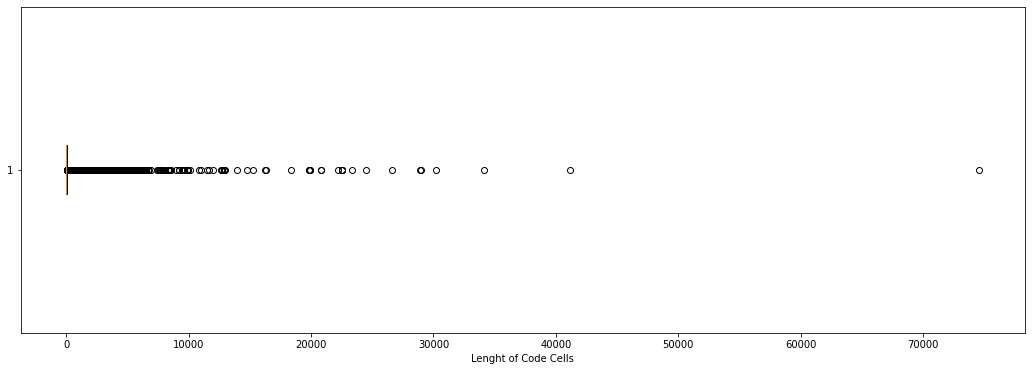

In [10]:
fig,ax= plt.subplots(figsize= (18,6))
plt.boxplot(code_lengths, vert = False)
plt.xlabel("Lenght of Code Cells");

<a id="3.2.2"></a>
### <span style="color:#e76f51;"> Code cells WordCloud  : </span>

In [11]:
# # show words cloud
# wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
#                       width = 600, height = 400,
#                       background_color='white').generate("".join(code_df["source"][:1000]))
# fig, ax = plt.subplots(figsize=(14,10))
# ax.imshow(wordcloud_notes, interpolation='bilinear')
# ax.set_axis_off()
# plt.imshow(wordcloud_notes);

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

## <span style="color:#e76f51;"> Markdown cells analysis  : </span>

<div style="font-size:14px; font-family:verdana; line-height: 1.7em; background-color:#FFD580;">
    📌 &nbsp;<b><u>Observations:</u></b><br>

* <i> Mean Length for Markdown Cells is <b><u>29 words</u></b></i><br>
* <i> Max words in a Markdown Cell is <b><u>38939 words</u></b></i><br>
* <i> There are many outliers in Markdown Cells as well.</i><br>
</div>

### <span style="color:#e76f51;"> Sample Markdown Cell: </span>

In [12]:
print(f'\033[94m')
print(mkd_df.iloc[59]["source"])


### Pipeline 

At this stage, it is worth introducing pipeline. In machine learning, it is common to run a sequence of algorithms to process and learn from data. In our example, we performed StringIndexer, VectorAssembler, and ML model. In other cases, the intermediate stages can be standardization, vectorization (for text processing), normalization, etc. These operations have to be performed on a specific order. Spark represents such a workflow as a Pipeline, which consists of a sequence of stages to be run in a specific order. Pipeline chains multiple Transformers and Estimators together to specify an ML workflow. 

Without the pipeline, we have to execute each stage, store the outcome, and feed into the next stage and evaluate, and so on. We prefer pipeline over this manual approach because of the following reasons: 

- The pipeline is less prone to mistake because the processes are automated. 
- In a production environment, this is the only way to do machine learning end to end. 


<a id="3.3.1"></a>
### <span style="color:#e76f51;"> Markdown Cells Length Distribution  : </span>

In [13]:
mkd_lengths = np.array([len(mkd_df ["source"][i].split()) for i in range(len(mkd_df))])
print(f'\033[94m Min Markdown Cells Length = ', min(mkd_lengths))
print(f'\033[94m Mean Markdown cells Length = ', round(np.mean(mkd_lengths),2))
print(f'\033[94m Max Markdown Cells Length = ', max(mkd_lengths))

 Min Markdown Cells Length =  1
 Mean Markdown cells Length =  29.42
 Max Markdown Cells Length =  38939


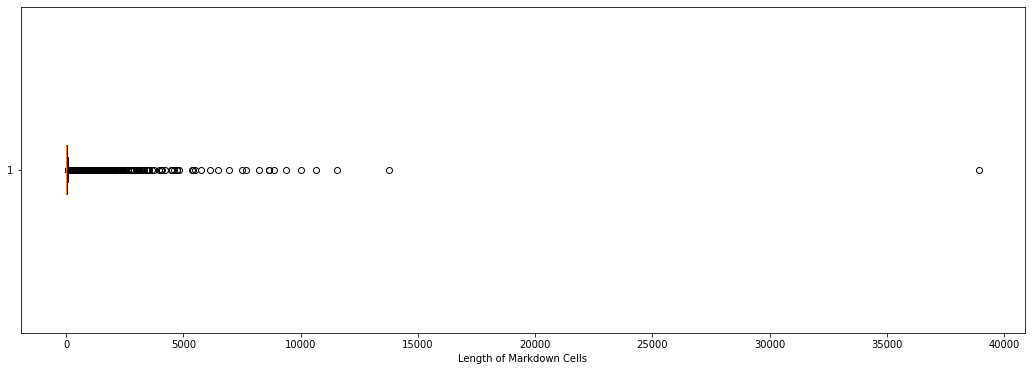

In [14]:
fig,ax= plt.subplots(figsize= (18,6))
plt.boxplot(mkd_lengths, vert = False)
plt.xlabel("Length of Markdown Cells");

<a id="3.3.3"></a>
### <span style="color:#e76f51;"> Markdown Cells WordCloud  : </span>

In [15]:
# # show words cloud
# wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
#                       width = 600, height = 400,
#                       background_color='white').generate("".join(mkd_df["source"][:1000]))
# fig, ax = plt.subplots(figsize=(14,10))
# ax.imshow(wordcloud_notes, interpolation='bilinear')
# ax.set_axis_off()
# plt.imshow(wordcloud_notes);

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3.2.3"></a>
### <span style="color:#e76f51;"> Code and Markdown cells Length After Cleaning  : </span>

In [16]:
####Source: https://www.kaggle.com/code/parulpandey/eda-and-preprocessing-for-bert

# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = text.strip()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

# code text preprocessing helped functions

def clean_code(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.replace('[', ' ').replace(']', ' ').replace('(', ' ').replace(')', ' ').replace('{', ' ').replace('}', ' ').replace('=', ' ').replace(',', ' ')
    text = text.lower()
    text = text.replace('_', '')
    text = text.replace('\n', ' ')
    text = text.replace('.', ' ')
    text = re.sub(r'".*"', ' ', text)
    text = re.sub(r"'.*'", ' ', text)
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

def code_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_code(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text


In [17]:
markdowns = df[df['cell_type'] == 'markdown']
codes = df[df['cell_type'] == 'code']

In [18]:
codes['source_clean'] = codes['source'].apply(str).apply(lambda x: code_preprocessing(x))
markdowns['source_clean'] = markdowns['source'].apply(str).apply(lambda x: text_preprocessing(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
train = pd.concat([codes, markdowns], ignore_index = True)
del codes, markdowns
_ = gc.collect()

In [20]:
train['text_len'] = train['source_clean'].astype(str).apply(len)
train['text_word_count'] = train['source_clean'].apply(lambda x: len(str(x).split()))

In [21]:
# markdowns = train[train['cell_type'] == 'markdown']
# codes = train[train['cell_type'] == 'code']

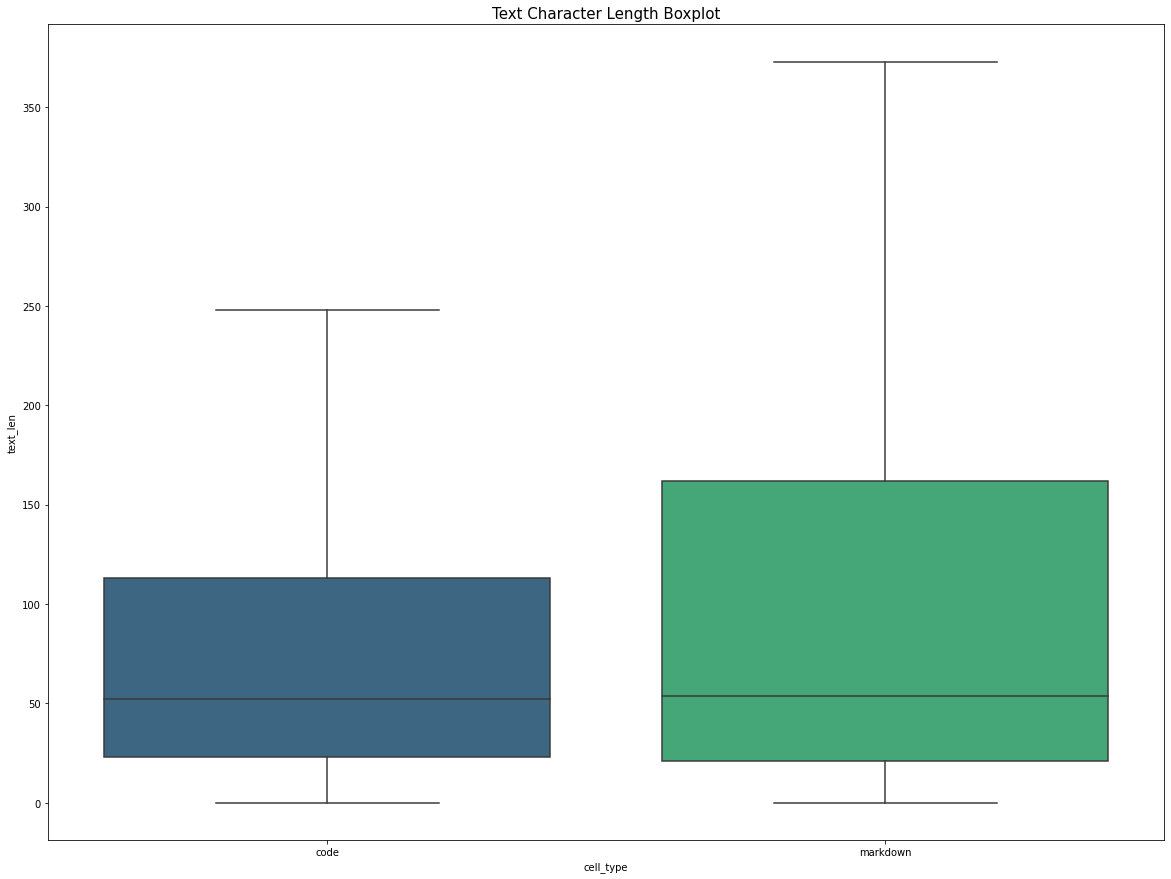

In [22]:
fig, ax = plt.subplots(figsize=(20, 15))

sns.boxplot(data=train,x = 'cell_type', y="text_len", palette = 'viridis', showfliers = False, ax=ax)
plt.title('Text Character Length Boxplot', size=15)
plt.show()

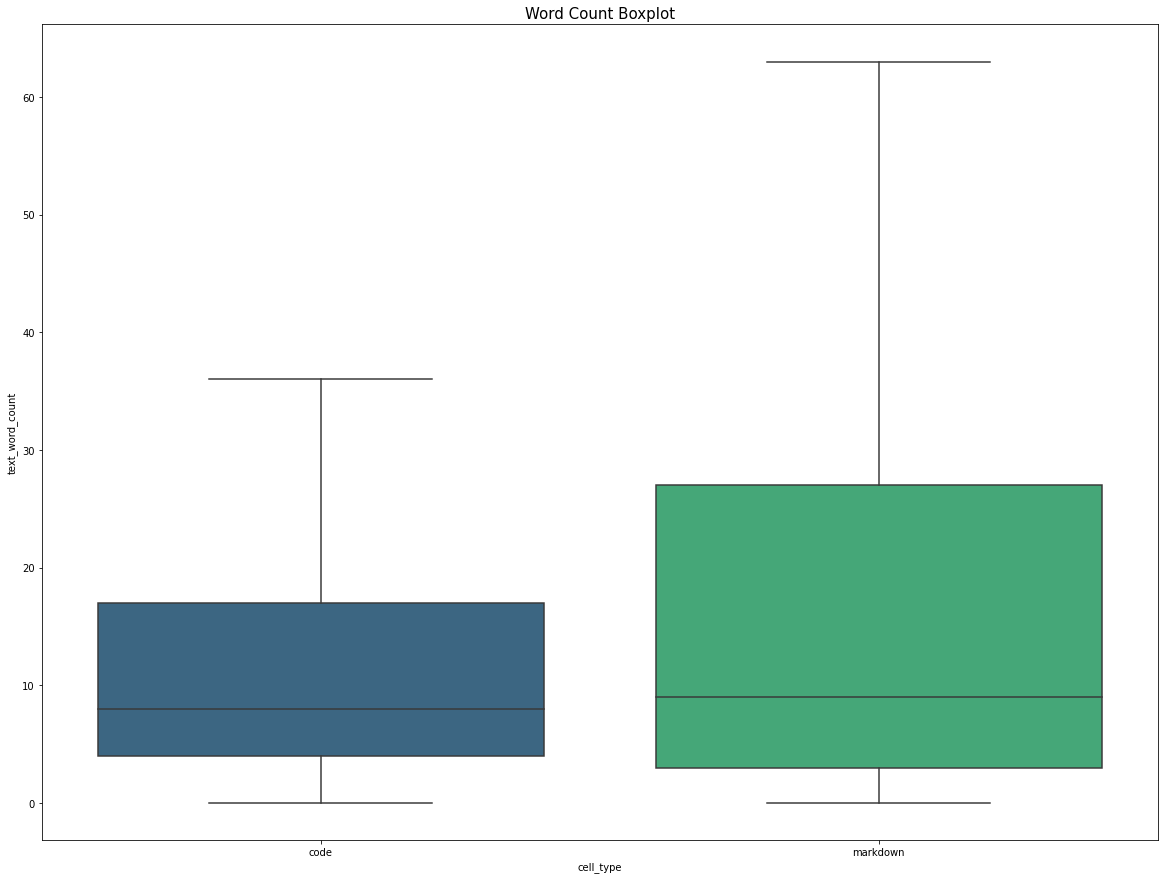

In [23]:
fig, ax = plt.subplots(figsize=(20, 15))

sns.boxplot(data=train,x = 'cell_type', y="text_word_count", palette = 'viridis', showfliers = False, ax=ax)
plt.title('Word Count Boxplot', size=15)
plt.show()

<a id="3.4"></a>
## <span style="color:#e76f51;"> Notebooks Analysis: </span>

<div style="font-size:14px; font-family:verdana; line-height: 1.7em; background-color:#FFD580;">
    📌 &nbsp;<b><u>Observations:</u></b><br>

* <i> Minimum count for both Code Cells and Markdown cells across all notebooks is <b><u>1</u></b>.</i><br>
* <i> Mean <b><u>Code cells</u></b> count across all notebooks is  <b><u>30 cells</u></b></i><br>
* <i> Mean <b><u>Markdown cells</u></b> count across all notebooks is  <b><u>15 cells</u></b></i><br>
* <i> Max count of <b><u>Code cells</u></b> and  <b><u>Markdown cells</u></b> across all notebooks is <b><u>809 cells</u></b> and <b><u>537 cells</u></b> respectively.</i><br>
  
</div>

In [24]:
## loading code_cell counts from notebooks 
notebook_ids = [notebook[:-5] for notebook in os.listdir("../input/AI4Code/train")]
code_counts= []
markdown_counts= [] 
for i in trange(len(notebook_ids)):
    temp_df = df.loc[(notebook_ids[i])]
    code_counts.append((temp_df["cell_type"] == "code").sum())
    markdown_counts.append((temp_df["cell_type"] == "markdown").sum())

counts_df = pd.DataFrame(data = np.array([notebook_ids, code_counts, markdown_counts, ]).T, columns = ["notebook_id", "code_count", "markdown_count"])
counts_df["markdown_count"] = counts_df["markdown_count"].astype(str).astype(int)
counts_df["code_count"] = counts_df["code_count"].astype(str).astype(int)
counts_df["total_count"] = counts_df["code_count"] + counts_df["markdown_count"]
print(f'\033[94m Minimum Cell count in any notebook', counts_df["total_count"].min())
print(f'\033[94m Maximum Cell count in any notebook', counts_df["total_count"].max())
print(f'\033[94m Mean of Cell counts across all notebooks', round(counts_df["total_count"].mean(), 2 ))
counts_df.head()

  0%|          | 0/139256 [00:00<?, ?it/s]

 Minimum Cell count in any notebook 2
 Maximum Cell count in any notebook 1005
 Mean of Cell counts across all notebooks 45.75


notebook_id  code_count  markdown_count  total_count
0  8a2564b730a575          11               1           12
1  38d64ca81d4a98          17              20           37
2  051d049a469e47          52              39           91
3  2142dd60936a39          15              10           25
4  6270fcdb7e77f4          18               6           24

### <span style="color:#e76f51;"> Outlier Notebooks Analysis: </span>

In [25]:
k = 100
top_k = counts_df.sort_values(by = ["total_count"], ascending=False)[:k]
fig = px.bar(data_frame=top_k, 
             x = "notebook_id" ,
             y = [ "code_count", "markdown_count"], 
             color_discrete_sequence=['#DE3163', '#58D68D']
         
            )
fig.update_layout(
    title={
        'text': "Cell Type Count analysis for top 100 cell count notebooks(OUTLIERS)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Notebook ID",
    yaxis_title="Count",
    template="plotly_white"
    
)
fig.update_traces(marker_line_color='black',
                  marker_line_width=0.9,opacity = 0.9)
fig.show()

<a id="3.4.1"></a>
### <span style="color:#e76f51;"> Code Cell Count Analysis: </span>

In [26]:
print(f'\033[94m Minimum Code Cell count in any notebook', counts_df["code_count"].min())
print(f'\033[94m Maximum Code Cell count in any notebook', counts_df["code_count"].max())
print(f'\033[94m Mean of Code Cell counts across all notebooks', round(counts_df["code_count"].mean(), 2 ))

 Minimum Code Cell count in any notebook 1
 Maximum Code Cell count in any notebook 809
 Mean of Code Cell counts across all notebooks 30.19


### <span style="color:#e76f51;"> Code Cell Count Distribution across all notebooks: </span>

In [27]:
fig = px.histogram(data_frame=counts_df, 
                   x= "code_count",
                   color_discrete_sequence=["#DE3163"],
                   marginal="violin")
fig.update_layout(
    title={
        'text': "Code Cell Count Distribution",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Code Cells",
    yaxis_title="Count",
    showlegend=False,
    template="plotly_white"
)
fig.show()
fig = px.histogram(data_frame=counts_df[counts_df["code_count"]<100], 
                   x= "code_count",
                   color_discrete_sequence=["#58D68D"],
                   marginal="violin")
fig.update_layout(
    title={
        'text': "Code Cell Count Distribution (COUNTS < 100 )",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Code Cells",
    yaxis_title="Count",
    showlegend=False,
    template="plotly_white"
)
fig.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3.4.2"></a>
### <span style="color:#e76f51;"> Markdown Cell Count Analysis: </span>

In [28]:
print(f'\033[94m Minimum Markdown Cell count in any notebook', counts_df["markdown_count"].min())
print(f'\033[94m Maximum Markdown Cell count in any notebook', counts_df["markdown_count"].max())
print(f'\033[94m Mean of Markdown Cell counts across all notebooks', round(counts_df["markdown_count"].mean(), 2 ))

 Minimum Markdown Cell count in any notebook 1
 Maximum Markdown Cell count in any notebook 537
 Mean of Markdown Cell counts across all notebooks 15.55


### <span style="color:#e76f51;"> Markdown Cell Count Distribution across all notebooks: </span>

In [29]:
fig = px.histogram(data_frame=counts_df, 
                   x= "markdown_count",
                   color_discrete_sequence=["#DE3163"],
                   marginal="violin")
fig.update_layout(
    title={
        'text': "Markdown Cell Count Distribution",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Markdown Cells",
    yaxis_title="Count",
    showlegend=False,
    template="plotly_white"
)

fig.show()
fig = px.histogram(data_frame=counts_df[counts_df["markdown_count"]<100], 
                   x= "markdown_count",
                   color_discrete_sequence=["#58D68D"],
                   marginal="violin")
fig.update_layout(
    title={
        'text': "Markdown Cell Count Distribution (COUNTS < 100 )",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Markdown Cells",
    yaxis_title="Count",
    showlegend=False,
    template="plotly_white"
)
fig.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3.4.3"></a>
## <span style="color:#e76f51;"> Minimum Cell Count Analysis: </span>

In [30]:
either_one = counts_df[(counts_df["markdown_count"] == 1) | (counts_df["code_count"] == 1 )] 
both_one = counts_df[(counts_df["markdown_count"] == 1) & (counts_df["code_count"] == 1 )] 
code_count_one = counts_df[counts_df["code_count"] == 1 ]
markdown_count_one  = counts_df[counts_df["markdown_count"] == 1 ]

print(f"\033[94mTotal notebook with either 1 code cell or 1 markdown cell = ", len(either_one))
print(f"\033[94mTotal notebook with both 1 code cell and 1 markdown cell = ", len(both_one ))
print(f"\033[94mNotebook counts with only 1 code cell  = " ,len(code_count_one))
print(f"\033[94mNotebook counts with only 1 markdown cell  = " ,len(markdown_count_one))

Total notebook with either 1 code cell or 1 markdown cell =  11426
Total notebook with both 1 code cell and 1 markdown cell =  392
Notebook counts with only 1 code cell  =  737
Notebook counts with only 1 markdown cell  =  11081


### <span style="color:#e76f51;"> Code cells count vs Markdown cells count: </span>

In [31]:
fig = px.scatter(data_frame=counts_df, 
                 x = "code_count", 
                 y = "markdown_count", 
                 size = "code_count",
                 color_discrete_sequence=["#DE3163"])
fig.add_shape(type='line',
                x0=0,
                y0=0,
                x1=800,
                y1=800,
                line=dict(color='Black'),
                xref='x',
                yref='y',name = "X=Y line"
             )
fig.update_layout(
    title={
        'text': "Code Cell Counts vs Markdown Cell Counts",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Code Cell Counts",
    yaxis_title="Markdown Cell Counts",
    showlegend=False,
    template="plotly_white"
)
fig.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

In [32]:

markdowns_df = df[df["cell_type"]=="markdown"].sample(10000).reset_index()

df_lang = pd.DataFrame(columns=["Count"])
failed_identifications = 0

# Check notebooks
for i, notebook in enumerate(tqdm(markdowns_df.id.unique())):
    
    # Add probs to df
    prob_df = pd.DataFrame(columns=["Prob"])
    
    # Look at text within notebook
    for txt in markdowns_df[markdowns_df.id == notebook].source:
        
        # Normalize a bit
        txt = re.sub(r'[^\w]', ' ', txt).strip()
        
        # Skip too long or too short txt
        if len(txt) > 5000 or len(txt.split(" ")) < 10:
            continue
            
        try:
            # Detect prob
            lang = detect_langs(txt)
            
            for l in lang:
                if l.lang in prob_df.index:
                    prob_df.loc[l.lang] = l.prob + prob_df.loc[l.lang]
                else:
                    prob_df.loc[l.lang] = l.prob
        except:
            failed_identifications += 1
    
    # Add highest prob. lang in notebook to counter
    if len(prob_df) > 0:
        lang = prob_df.sort_values("Prob", ascending=False).index[0]

        if lang in df_lang.index:
             df_lang.loc[lang, "Count"] = 1 + df_lang.loc[lang, "Count"]
        else:
             df_lang.loc[lang, "Count"] = 1
    
df_lang = df_lang.sort_values("Count", ascending=False)

  0%|          | 0/9331 [00:00<?, ?it/s]

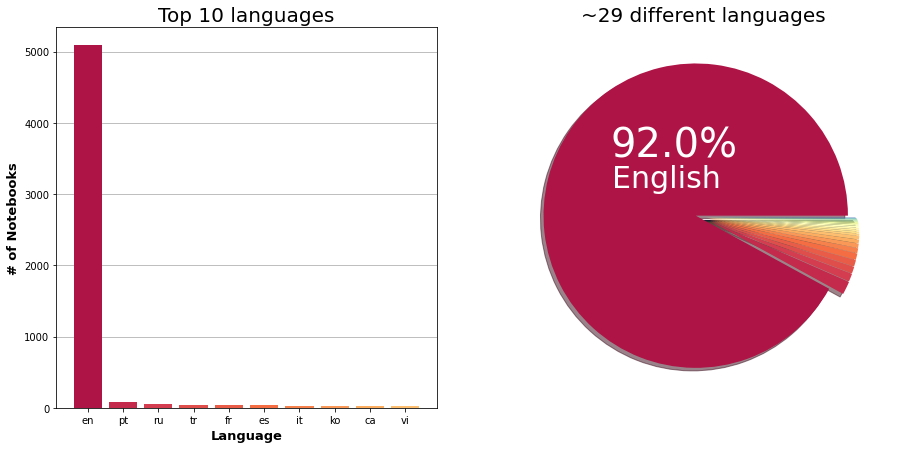

In [33]:

colors = sns.color_palette("Spectral", n_colors=len(df_lang))

dt = df_lang.sort_values("Count", ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

explode = np.flip(np.linspace(0, 0.05, len(df_lang)))

axs[1].pie(dt.Count, colors=colors, explode=explode, shadow=True);

top = np.round(dt.Count.en / dt.Count.sum(), 2) * 100
axs[1].text(-0.61, 0.40, f"{top}%", size=40, c="white")
axs[1].text(-0.6, 0.2, f"English", size=30, c="white")
axs[1].set_title(f"~{len(df_lang)} different languages", size=20)

axs[0].grid(True, axis="y", zorder=0)
axs[0].bar(df_lang.sort_values("Count", ascending=False).head(10).index, 
           df_lang.sort_values("Count", ascending=False).head(10).Count, color=colors[:10], zorder=3)

axs[0].set_title("Top 10 languages", size=20)
axs[0].set_ylabel("# of Notebooks", size=13, weight="bold")
axs[0].set_xlabel("Language", size=13, weight="bold");